# RAG w/ Langgraph
랭그래프에 RAG 추가하기

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# RAG 준비

# 1. Loader
from langchain_community.document_loaders import WebBaseLoader
from bs4.filter import SoupStrainer

loader = WebBaseLoader(
    web_paths=('https://lilianweng.github.io/posts/2023-06-23-agent/',),  # 여러개 가져오려면 튜플 안에 추가하면 됨
    # 웹페이지에서 필요한 정보를 선택하기
    bs_kwargs={
        'parse_only': SoupStrainer(class_=['post-content'])
    },
    # header_template={},
)
docs = loader.load()

# 웹페이지를 그대로 긁어오면, 필요없는 부분(사이트 제목, 밑에 광고들, 등등)이 뒤섞여서 나온다. -> 필요한 부분을 선택적으로 가져와야 함 -> bs_kwargs
# from pprint import pprint
# pprint(docs[0].page_content)

# 2. Splitter
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=500
)
splitted_docs = splitter.split_documents(docs)
# print(len(splitted_docs))

# 3. Enbedding Model
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings(model='text-embedding-3-small')  # small <-> large

# 4. Vectorstore (일단은 FAISS, 나중엔 클라우드(Pinecone)에 저장할 것)
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(splitted_docs, embedding=embedding)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
# 프롬프트
from langchain import hub

prompt = hub.pull('rlm/rag-prompt')
for msg in prompt.messages:
    msg.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


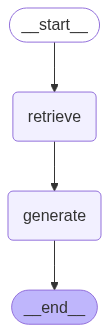

In [4]:
# 랭그래프

# 1. State
from typing_extensions import TypedDict, List
from langchain_core.documents import Document

class State(TypedDict):
    # 프롬프트에 뚫린 구멍은 반드시 채워줘야함
    question: str  # 사용자의 질문
    context: List[Document]  # LLM에게 전달할 RAG 데이터의 문서조각. List[Document]는 context에 Document 객체가 리스트로 모여있을 것이라는 의미
    answer: str  # LLM의 답안

# 2. Node
# 2-1. 검색노드
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state['question'], k=4)  # [Document 타입 객체 x 4]
    return {'context': retrieved_docs}  # 언급하지 않은 state 항목들(question, answer)은 내부적으로 알아서 그대로 들어가짐

# 2-2. 답변생성노드
from langchain_openai import ChatOpenAI

def generate(state: State):

    # 내용에 해당하는 page_content만 모아서 토큰 절약
    context_str = ''
    for doc in state['context']:
        context_str += doc.page_content + '\n-----------------------------------------------\n'

    question_with_context = prompt.invoke({'question': state['question'], 'context': context_str})
    llm = ChatOpenAI(model='gpt-4.1', temperature=0)
    res = llm.invoke(question_with_context)    
    return {'answer': res.content}

# 3. Graph
from langgraph.graph import START, END, StateGraph

builder = StateGraph(State)

builder.add_node('retrieve', retrieve)
builder.add_node('generate', generate)

builder.add_edge(START, 'retrieve')
builder.add_edge('retrieve', 'generate')
builder.add_edge('generate', END)

graph = builder.compile()

# 4. 시각화
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
final_state = graph.invoke({'question': '에이전트 시스템에 대해 알려줘'}) 

print(final_state['answer'])

에이전트 시스템은 주어진 목표를 달성하기 위해 자율적으로 작업을 수행하는 소프트웨어 구조입니다. LLM(대형 언어 모델) 기반 에이전트 시스템은 인터넷 검색, 장기 기억 관리, 파일 출력, 외부 API 호출 등 다양한 도구를 활용해 복잡한 문제를 해결할 수 있습니다. 또한, 자신의 행동을 지속적으로 평가하고 효율적으로 작업을 수행하도록 설계되어 있습니다.


## RAG +a

### 메타데이터 편집
원본 내용은 그대로 두되, 추가적으로 넣고 싶은 내용을 추가/삭제할 수 있다

In [6]:
# splitted_docs를 나눠서 전/중/후반부를 메타데이터에 추가하고 싶음
third = len(splitted_docs) // 3

for idx, doc in enumerate(splitted_docs):
    if idx < third:
        doc.metadata['section'] = 'beginning'
    elif idx < third * 2:
        doc.metadata['section'] = 'middle'        
    else:
        doc.metadata['section'] = 'end'
print(splitted_docs[0].metadata)

vectorstore = FAISS.from_documents(splitted_docs, embedding=embedding) 

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'beginning'}


### 쿼리 분석/개선

질문이 이어질 때, 이전 질문 내용을 사용해야 하는 질문이 들어오는 경우가 있다.

지금 질문 + 이전 질문 내용과 답변 내용을 LLM에 넣어서, 새로 적합한 쿼리를 만들어서 RAG를 돌려줘야 함

In [7]:
# 쿼리를 분석해서, 질문에 전/중/후반부가 있다면 메타데이터를 참고하면 좋겠음
from typing import Literal  # 말 그대로
from typing_extensions import Annotated  # 첨언, 주석


# StructuredOutput에서 사용하기 좋다. pydantic이랑 비슷한거
class Search(TypedDict):
    '''Vectorstore Search Query'''
    # Annotated[타입(str), NOT NULL(... : 비어있지 않다), 설명(이 항목에 대한 설명)]
    query: Annotated[str, ..., 'search query to run']
    section: Annotated[
        Literal['beginning', 'middle', 'end'],  # section은 전/중/후반부만 존재함
        ...,
        'Section to query'
    ]
    
# question / query: question보다 좀 더 유사도 검색이 잘 되게 하는 query가 필요함
class MyState(TypedDict):
    question: str  
    query: Search  # 이 쿼리는 Search를 참고할 것 -> state를 더 자세하게 정의하기 위해 따로 정의한 class Search
    context: List[Document]
    answer: str

In [12]:
llm = ChatOpenAI(model='gpt-4.1', temperature=0)

s_llm = llm.with_structured_output(Search)  # 답변이 무조건 Search 클래스의 인스턴스로 나온다
s_llm.invoke('그그 문서 앞쪽에 LLM 작ㅇ업 분해인가 하는 그게 뭐야')  # 벡터스토어에 비교하기 훨씬 좋게 맞춰준다. 기준은 Search 클래스의 docstring에 써있는 그대로.

{'query': 'LLM 작업 분해', 'section': 'beginning'}

In [13]:
def analyze_query(state: MyState):
    # Search 클래스에 맞게 사용자의 question을 {query, section}으로 바꿔줌
    s_llm = llm.with_structured_output(Search)  # 답변이 무조건 Search 클래스의 인스턴스로 나온다
    query = s_llm.invoke(state['question'])
    return {'query': query}

def retrieve(state: MyState):
    query = state['query']
    retrieved_docs = vectorstore.similarity_search(
        query['query'], 
        # 필터함수를 돌려서 section이 쿼리의 section과 맞을 경우만 추려냄
        filter=lambda metadata: metadata.get('section') == query['section']  # 벡터스토어의 결과에도 검증함수를 걸 수 있고, 그냥 데이터만이 아니라 메타데이터도 조건에 걸 수 있다. 
    )
    return {'context': retrieved_docs}  # 언급하지 않은 state 항목들(question, answer)은 내부적으로 알아서 그대로 들어가짐

def generate(state: MyState):
    context_str = ''
    for doc in state['context']:
        context_str += doc.page_content + '\n-----------------------------------------------\n'

    question_with_context = prompt.invoke({'question': state['question'], 'context': context_str})
    res = llm.invoke(question_with_context)    
    return {'answer': res.content}

builder = StateGraph(State)

builder.add_node('analyze_query', analyze_query)
builder.add_node('retrieve', retrieve)
builder.add_node('generate', generate)

builder.add_edge(START, 'analyze_query')
builder.add_edge('analyze_query', 'retrieve')
builder.add_edge('retrieve', 'generate')
builder.add_edge('generate', END)

graph = builder.compile()

In [ ]:
graph.invoke({'question': '그그 문서 앞쪽에 LLM 작ㅇ업 분배인가 하는 그게 뭐야'})  # 메타데이터를 'beginning' 만 가져온 걸 알 수 있음

{'question': '그그 문서 앞쪽에 LLM 작ㅇ업 분배인가 하는 그게 뭐야',
 'context': [Document(id='f2ca9a03-24d9-4c81-a689-e278866313a7', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'beginning'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially